In [2]:
#omport some libraries
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import random
import datetime as dt
import pmdarima as pm
import matplotlib.pyplot as plt

# For time series modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
import warnings
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima
from pandas.plotting import lag_plot

Loading data

In [6]:
#load macroeconomic factors data data from saved csv file downloaded from FRED

unemp = pd.read_csv("UNRATE.csv", parse_dates = ['Date'])       #unemployment rate in Percent
#unemp

intr = pd.read_csv("FEDFUNDS.csv", parse_dates = ['Date'])      #interest rate in Percent
#intr

cpi = pd.read_csv("CPI5.csv", parse_dates = ['Date'])           #inflation in Index point 1982-1984=100
#cpi

gdp = pd.read_csv("GDP5.csv", parse_dates = ['Date'])\
      .assign(GDP = lambda cols: cols['GDP']/10)                #gross domestic product in 10 billions of Dollars     
#gdp


In [7]:
#load S&P500 data from saved csv file downloaded from FRED

snp = pd.read_csv("SP500.csv", parse_dates = ['Date'])\
      .assign(SP500 = lambda cols: cols['SP500']/10)             #S&P in Index point

#snp

Data Merging and interpolation

In [8]:
df = pd.merge(
        left = snp,
        right = unemp,
        on = 'Date',
        how = 'outer').sort_values(by = 'Date', ascending = True)
df['UNRATE'] = df['UNRATE'].interpolate(method='linear', limit_direction = 'backward')

#df

In [9]:
df1 = pd.merge(
        left = snp,
        right = intr,
        on = 'Date',
        how = 'outer').sort_values(by = 'Date', ascending = True)
df1['INTR'] = df1['INTR'].interpolate(method='linear', limit_direction = 'backward')

#df1

In [10]:
df2 = pd.merge(
        left = snp,
        right = cpi,
        on = 'Date',
        how = 'outer').sort_values(by = 'Date', ascending = True)
df2['CPI'] = df2['CPI'].interpolate(method='linear', limit_direction = 'backward')

#df2

In [11]:
df3 = pd.merge(
        left = snp,
        right = gdp,
        on = 'Date',
        how = 'outer').sort_values(by = 'Date', ascending = True)
df3['GDP'] = df3['GDP'].interpolate(method='linear', limit_direction = 'backward')

#df3

In [12]:
unemp_avg_growth_rate = (df['UNRATE']/df['UNRATE'].shift(1)).dropna().tail(5).mean()
#unemp_avg_growth_rate

for i in range(df.shape[0]):
    if(pd.isnull(df.loc[i,'UNRATE'])):
        df.loc[i,'UNRATE'] = df.loc[i-1,'UNRATE'] * unemp_avg_growth_rate

df = df.dropna(axis=0, how='any').reset_index(drop=True)        
        
#df

In [13]:
intr_avg_growth_rate = (df1['INTR']/df1['INTR'].shift(1)).dropna().tail(5).mean()
#intr_avg_growth_rate

for i in range(df1.shape[0]):
    if(pd.isnull(df1.loc[i,'INTR'])):
        df1.loc[i,'INTR'] = df1.loc[i-1,'INTR'] * intr_avg_growth_rate

df1 = df1.dropna(axis=0, how='any').reset_index(drop=True)        
        
#df1

In [14]:
cpi_avg_growth_rate = (df2['CPI']/df2['CPI'].shift(1)).dropna().tail(5).mean()
#cpi_avg_growth_rate

for i in range(df2.shape[0]):
    if(pd.isnull(df2.loc[i,'CPI'])):
        df2.loc[i,'CPI'] = df2.loc[i-1,'CPI'] * cpi_avg_growth_rate

df2 = df2.dropna(axis=0, how='any').reset_index(drop=True)        
        
#df2

In [15]:
gdp_avg_growth_rate = (df3['GDP']/df3['GDP'].shift(1)).dropna().tail(5).mean()
#gdp_avg_growth_rate

for i in range(df3.shape[0]):
    if(pd.isnull(df3.loc[i,'GDP'])):
        df3.loc[i,'GDP'] = df3.loc[i-1,'GDP'] * gdp_avg_growth_rate

df3 = df3.dropna(axis=0, how='any').reset_index(drop=True)        
        
#df3

In [16]:
dfx = pd.merge(pd.merge(pd.merge(df,df1,on=['Date','SP500']),df2,on=['Date','SP500']),df3,on=['Date','SP500'])
dfx

,Date,SP500,UNRATE,INTR,CPI,GDP
0,2017-12-26,268.050,4.080000,1.322000,247.992600,1994.689720
1,2017-12-27,268.262,4.060000,1.344000,248.180200,1999.904440
2,2017-12-28,268.754,4.040000,1.366000,248.367800,2005.119160
3,2017-12-29,267.361,4.020000,1.388000,248.555400,2010.333880
4,2018-01-02,269.581,4.004348,1.410435,248.773261,2016.032771
...,...,...,...,...,...,...
1254,2022-12-19,381.766,3.700000,5.063797,298.792924,2662.509238
1255,2022-12-20,382.162,3.700000,5.107532,298.805990,2663.266994
1256,2022-12-21,387.844,3.700000,5.151646,298.819058,2664.024966
1257,2022-12-22,382.239,3.700000,5.196140,298.832125,2664.783154


In [17]:
dfx.set_index('Date', drop=True, inplace=True)
dfx

,SP500,UNRATE,INTR,CPI,GDP
Date,,,,,
2017-12-26,268.050,4.080000,1.322000,247.992600,1994.689720
2017-12-27,268.262,4.060000,1.344000,248.180200,1999.904440
2017-12-28,268.754,4.040000,1.366000,248.367800,2005.119160
2017-12-29,267.361,4.020000,1.388000,248.555400,2010.333880
2018-01-02,269.581,4.004348,1.410435,248.773261,2016.032771
...,...,...,...,...,...
2022-12-19,381.766,3.700000,5.063797,298.792924,2662.509238
2022-12-20,382.162,3.700000,5.107532,298.805990,2663.266994
2022-12-21,387.844,3.700000,5.151646,298.819058,2664.024966


In [19]:
dfx = dfx.dropna()          #drop null values
dfx

,SP500,UNRATE,INTR,CPI,GDP
Date,,,,,
2017-12-26,268.050,4.080000,1.322000,247.992600,1994.689720
2017-12-27,268.262,4.060000,1.344000,248.180200,1999.904440
2017-12-28,268.754,4.040000,1.366000,248.367800,2005.119160
2017-12-29,267.361,4.020000,1.388000,248.555400,2010.333880
2018-01-02,269.581,4.004348,1.410435,248.773261,2016.032771
...,...,...,...,...,...
2022-12-19,381.766,3.700000,5.063797,298.792924,2662.509238
2022-12-20,382.162,3.700000,5.107532,298.805990,2663.266994
2022-12-21,387.844,3.700000,5.151646,298.819058,2664.024966


In [20]:
dfx.describe()

,SP500,UNRATE,INTR,CPI,GDP
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,344.609449,4.945259,1.252362,266.121607,2249.818864
std,66.996595,2.266145,1.145820,15.532900,196.570805
min,223.740000,3.500000,0.050000,247.992600,1963.673100
25%,284.047500,3.645455,0.090000,255.099429,2091.764530
50%,327.103000,3.876190,1.451500,258.893957,2163.506668
75%,402.893500,5.809091,2.171190,276.104000,2429.466411
max,479.656000,14.700000,5.241018,298.845194,2665.541557


(array([ 17., 176., 314., 120.,  93.,  77., 147., 112., 135.,  68.]),
 array([223.74  , 249.3316, 274.9232, 300.5148, 326.1064, 351.698 ,
        377.2896, 402.8812, 428.4728, 454.0644, 479.656 ]),
 <a list of 10 Patch objects>)

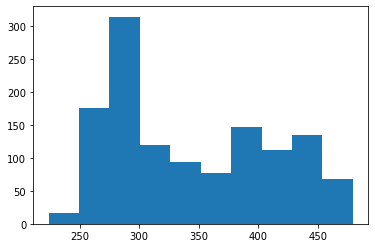

In [21]:
plt.hist(dfx['SP500'])

Text(0.5, 1.0, 'original S&P500')

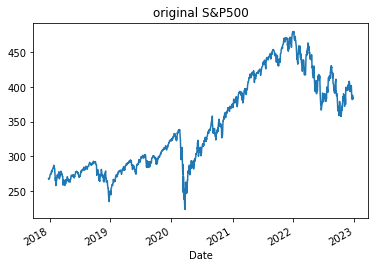

In [22]:
ax = dfx['SP500'].plot()
plt.title('original S&P500')

In [23]:
print(dfx.corr())                          #correlation

           SP500    UNRATE      INTR       CPI       GDP
SP500   1.000000 -0.102399 -0.411642  0.790013  0.837962
UNRATE -0.102399  1.000000 -0.544322 -0.203992 -0.299577
INTR   -0.411642 -0.544322  1.000000  0.064336  0.061801
CPI     0.790013 -0.203992  0.064336  1.000000  0.978838
GDP     0.837962 -0.299577  0.061801  0.978838  1.000000


Plots of S&P500 with each factor

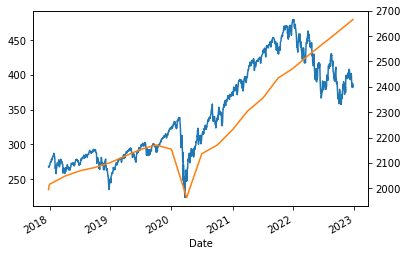

In [83]:
ax = dfx['SP500'].plot()
ax = dfx['GDP'].plot(ax=ax, secondary_y=True)

plt.show()

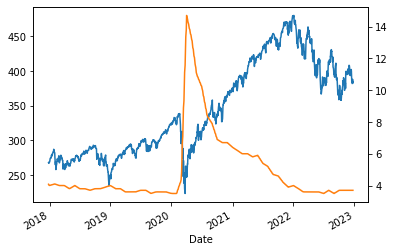

In [25]:
ax = dfx['SP500'].plot()
ax = dfx['UNRATE'].plot(ax=ax, secondary_y=True)
plt.show()

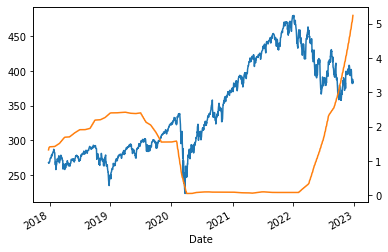

In [26]:
ax = dfx['SP500'].plot()
ax = dfx['INTR'].plot(ax=ax, secondary_y=True)
plt.show()

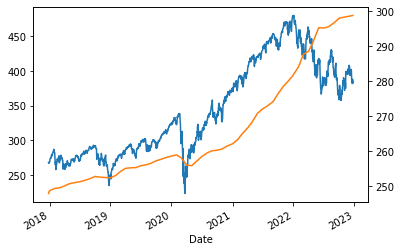

In [27]:
ax = dfx['SP500'].plot()
ax = dfx['CPI'].plot(ax=ax, secondary_y=True)
plt.show()

Check stationarity: if p>0.05 then, data is not stationary

In [38]:
import statsmodels.tsa.stattools as tools

In [39]:
p_value1 = tools.adfuller(dfx['SP500'], regression='nc')[1]
print('p-value1: {}'.format(p_value1))
p_value2 = tools.adfuller(dfx['UNRATE'], regression='nc')[1]
print('p-value2: {}'.format(p_value2))
p_value3 = tools.adfuller(dfx['INTR'], regression='nc')[1]
print('p-value3: {}'.format(p_value3))
p_value4 = tools.adfuller(dfx['CPI'], regression='nc')[1]
print('p-value4: {}'.format(p_value4))
p_value5 = tools.adfuller(dfx['GDP'], regression='nc')[1]
print('p-value5: {}'.format(p_value5))


p-value1: 0.8188218813176582
p-value2: 0.40076491275504056
p-value3: 0.9247713907830476
p-value4: 0.9998445009720776
p-value5: 0.9850467840283395


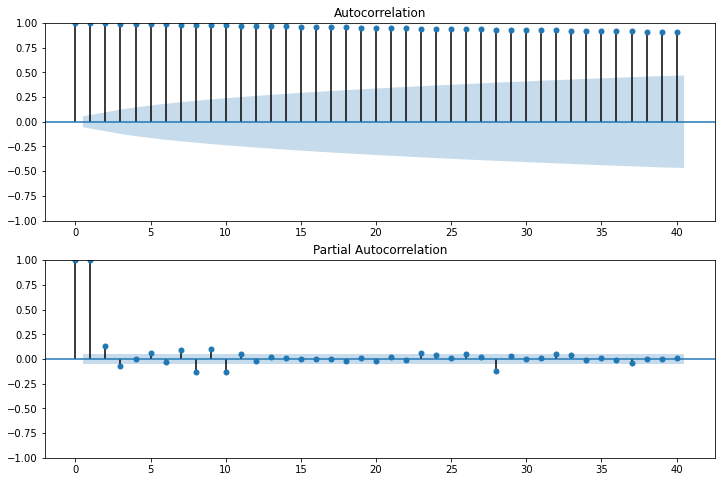

In [28]:
#ACF and PACF plots of S&p500 data which has to be predicted

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfx['SP500'].dropna(), lags=40, ax=ax1)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfx['SP500'].dropna(), lags=40, ax=ax1)

set p=2 from (PACF), d=1 (first order differencing), q=0 (from ACF)

Text(0.5, 1.0, 'differenced S&P500')

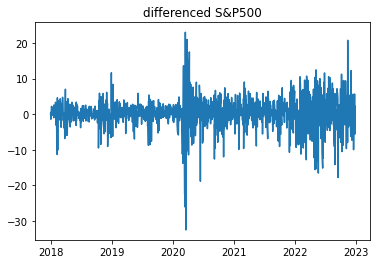

In [33]:
### lets try differencing
#plt.figure(figsize=(16,7))
fig = plt.figure(1)
df_diff = dfx - dfx.shift()
#plt.plot(df_diff)
plt.plot(df_diff['SP500'])

#determining rolling statistics
#rollmean = df_diff.rolling(12).mean()
#rollstd = df_diff.rolling(12).std()

#plot rolling stats
#orig = plt.plot(df_diff, color='blue', label='original')
#mean = plt.plot(rollmean, color='red', label='rolling mean')
#std = plt.plot(rollstd, color='black', label='rolling std')
#plt.legend(loc='best')
plt.title('differenced S&P500')
#plt.show(block = False)

In [34]:
df_diff

,SP500,UNRATE,INTR,CPI,GDP
Date,,,,,
2017-12-26,NaN,NaN,NaN,NaN,NaN
2017-12-27,0.212,-0.020000,0.022000,0.187600,5.214720
2017-12-28,0.492,-0.020000,0.022000,0.187600,5.214720
2017-12-29,-1.393,-0.020000,0.022000,0.187600,5.214720
2018-01-02,2.220,-0.015652,0.022435,0.217861,5.698891
...,...,...,...,...,...
2022-12-19,-3.470,0.000000,0.043361,0.013066,0.757541
2022-12-20,0.396,0.000000,0.043735,0.013067,0.757756
2022-12-21,5.682,0.000000,0.044113,0.013067,0.757972


In [35]:
df_diff = df_diff.dropna()

(array([  1.,   2.,   3.,  23., 101., 602., 458.,  57.,   7.,   4.]),
 array([-32.489 , -26.9363, -21.3836, -15.8309, -10.2782,  -4.7255,
          0.8272,   6.3799,  11.9326,  17.4853,  23.038 ]),
 <a list of 10 Patch objects>)

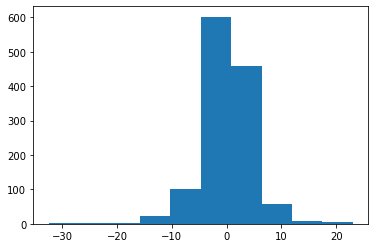

In [36]:
plt.hist(df_diff['SP500'])               #data looks normal distributed now

In [40]:
p_value1 = tools.adfuller(df_diff['SP500'], regression='nc')[1]
print('p-value1: {}'.format(p_value1))
p_value2 = tools.adfuller(df_diff['UNRATE'], regression='nc')[1]
print('p-value2: {}'.format(p_value2))
p_value3 = tools.adfuller(df_diff['INTR'], regression='nc')[1]
print('p-value3: {}'.format(p_value3))
p_value4 = tools.adfuller(df_diff['CPI'], regression='nc')[1]
print('p-value4: {}'.format(p_value4))
p_value5 = tools.adfuller(df_diff['GDP'], regression='nc')[1]
print('p-value5: {}'.format(p_value5))

p-value1: 9.21466694229674e-20
p-value2: 1.3363449366410747e-06
p-value3: 0.0864252759989057
p-value4: 0.0070661213546728725
p-value5: 0.0015590397466145047


In [41]:
df_diff['INTR'] = df_diff['INTR'].diff()               #differencing interest rate again

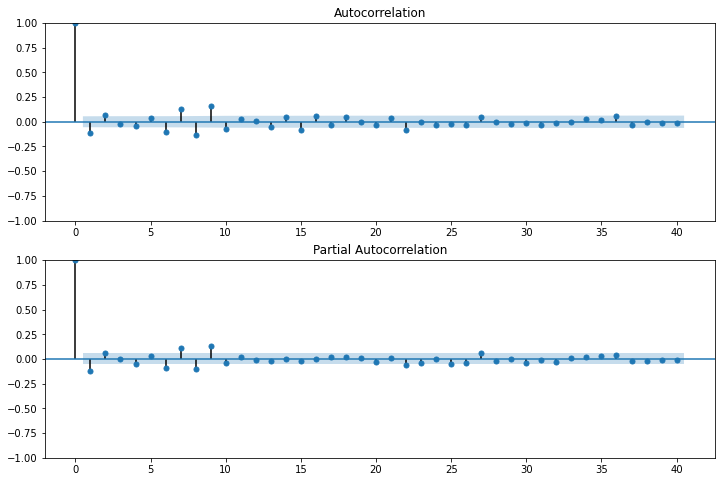

In [48]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff['SP500'].dropna(), lags=40, ax=ax1)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff['SP500'].dropna(), lags=40, ax=ax1)

set p,d,q also as (1,1,1)

In [45]:
#set all macroeconomic factors in exog dataframe
exog = df_diff[['CPI','GDP','UNRATE','INTR']]
exog

,CPI,GDP,UNRATE,INTR
Date,,,,
2017-12-27,0.187600,5.214720,-0.020000,NaN
2017-12-28,0.187600,5.214720,-0.020000,-2.220446e-16
2017-12-29,0.187600,5.214720,-0.020000,2.220446e-16
2018-01-02,0.217861,5.698891,-0.015652,4.347826e-04
2018-01-03,0.030261,0.484171,0.004348,-2.200000e-02
...,...,...,...,...
2022-12-19,0.013066,0.757541,0.000000,3.712950e-04
2022-12-20,0.013067,0.757756,0.000000,3.745018e-04
2022-12-21,0.013067,0.757972,0.000000,3.777363e-04


In [46]:
df_diff = df_diff.drop('2017-12-27')
df_diff

,SP500,UNRATE,INTR,CPI,GDP
Date,,,,,
2017-12-28,0.492,-0.020000,-2.220446e-16,0.187600,5.214720
2017-12-29,-1.393,-0.020000,2.220446e-16,0.187600,5.214720
2018-01-02,2.220,-0.015652,4.347826e-04,0.217861,5.698891
2018-01-03,1.725,0.004348,-2.200000e-02,0.030261,0.484171
2018-01-04,1.093,0.004348,0.000000e+00,0.030261,0.484171
...,...,...,...,...,...
2022-12-19,-3.470,0.000000,3.712950e-04,0.013066,0.757541
2022-12-20,0.396,0.000000,3.745018e-04,0.013067,0.757756
2022-12-21,5.682,0.000000,3.777363e-04,0.013067,0.757972


In [47]:
exog = exog.dropna()
exog

,CPI,GDP,UNRATE,INTR
Date,,,,
2017-12-28,0.187600,5.214720,-0.020000,-2.220446e-16
2017-12-29,0.187600,5.214720,-0.020000,2.220446e-16
2018-01-02,0.217861,5.698891,-0.015652,4.347826e-04
2018-01-03,0.030261,0.484171,0.004348,-2.200000e-02
2018-01-04,0.030261,0.484171,0.004348,0.000000e+00
...,...,...,...,...
2022-12-19,0.013066,0.757541,0.000000,3.712950e-04
2022-12-20,0.013067,0.757756,0.000000,3.745018e-04
2022-12-21,0.013067,0.757972,0.000000,3.777363e-04


Trying Machine Learning models: Regression ARIMAX with p,d,q as (2,1,0) and (1,1,1)

In [59]:
model3=sm.tsa.ARIMA(endog=df_diff['SP500'],exog= exog,order=[1,1,1])
results3=model3.fit()
print(results3.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3657.192
Date:                Tue, 10 Jan 2023   AIC                           7328.383
Time:                        19:49:49   BIC                           7364.333
Sample:                             0   HQIC                          7341.895
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI           -3.9580      2.508     -1.578      0.115      -8.874       0.958
GDP            0.1970      0.144      1.364      0.173      -0.086       0.480
UNRATE        -4.7317      1.257     -3.765      0.0

In [69]:
#with arima(1,1,1) p>z of unrate is less than 0.05 i.e. only this factor is significant here which is impacting S&P500

In [60]:
model4 =sm.tsa.ARIMA(endog=df_diff['SP500'],exog= exog,order=[2,1,0])
results4=model4.fit()
print(results4.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                 1257
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3837.241
Date:                Tue, 10 Jan 2023   AIC                           7688.481
Time:                        19:50:12   BIC                           7724.431
Sample:                             0   HQIC                          7701.993
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI          -13.7496      7.217     -1.905      0.057     -27.894       0.395
GDP            0.7465      0.432      1.728      0.084      -0.100       1.593
UNRATE         5.8064      3.280      1.770      0.0

In [70]:
#with arima(2,1,0) p>z of none factor is less than 0.05 i.e. no factor is much significant here which is impacting S&P500

Fitting auto_arima model to check which model can be better by check AIC

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7351.307, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7335.850, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7337.817, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7349.842, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7333.525, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7335.507, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7335.519, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7334.808, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7336.747, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7332.122, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7334.524, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7334.109, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7334.118, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7333.452, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]          

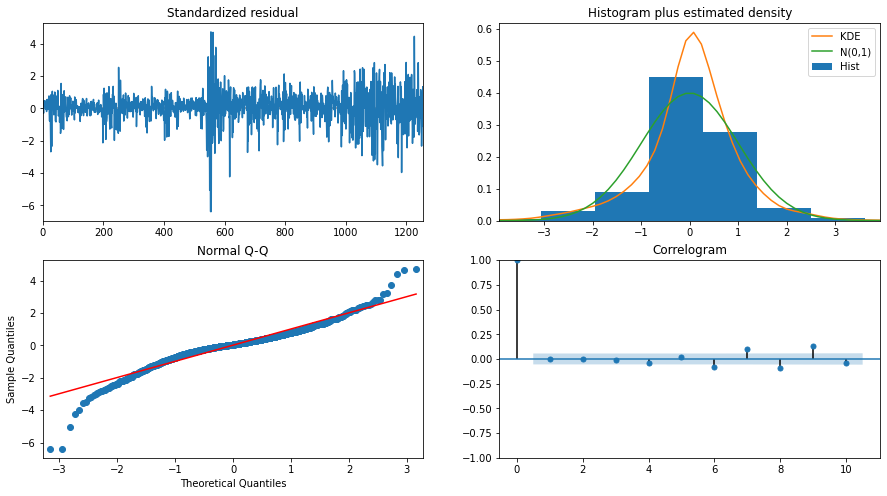

In [68]:
model_autoARIMA = auto_arima(dfx['SP500'], exogenous = exog, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

fitting model (2,1,0)

In [49]:
arimax_model = ARIMA(df_diff['SP500'], order=(2,1,0), exog = exog).fit()

In [50]:
#diving data as trainig and testing data
train = df_diff[:1000]
test = df_diff[1000:]

In [51]:
len(train), (len(df_diff)), len(test)

(1000, 1257, 257)

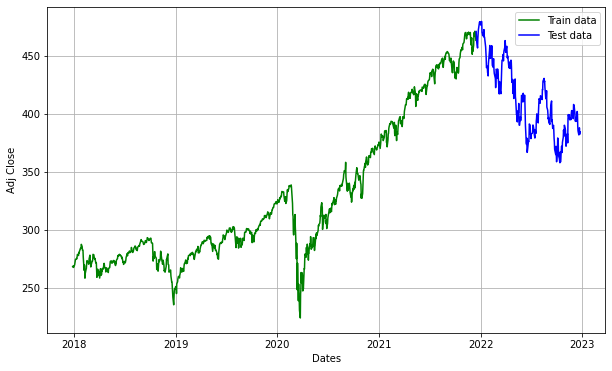

In [80]:
#split data into train n test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adj Close')
plt.plot(dfx['SP500'][0:1000], 'green', label = 'Train data')
plt.plot(dfx['SP500'][1000:], 'blue', label = 'Test data')
plt.legend()

In [53]:
#predicting testing values
pred = arimax_model.predict(start=len(train), end=(len(df_diff)-1))
pred

Date
2021-12-17    1.352554
2021-12-20   -0.435423
2021-12-21   -4.680253
2021-12-22   -2.141202
2021-12-23    2.980598
                ...   
2022-12-19   -6.242555
2022-12-20   -5.987997
2022-12-21   -2.896572
2022-12-22    0.301836
2022-12-23    1.443911
Name: predicted_mean, Length: 257, dtype: float64

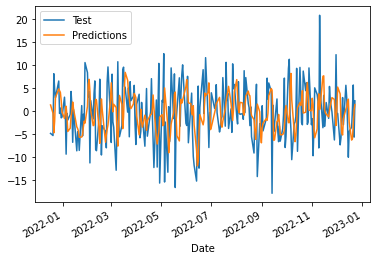

In [54]:
#train.plot(legend=True, label='Train', figsize= (10,6))
test['SP500'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Predictions')

In [55]:
#Getting original data back
ARIMA_diff_predictions = pd.Series(arimax_model.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

ARIMA_prediction = pd.Series(dfx['SP500'].iloc[0], index=dfx['SP500'].index)
ARIMA_prediction = ARIMA_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_prediction.head()

Date
2017-12-28    1.197388
2017-12-29    0.492019
2018-01-02   -0.316394
2018-01-03   -1.269710
2018-01-04    0.000340
dtype: float64
Date
2017-12-28    1.197388
2017-12-29    1.689407
2018-01-02    1.373013
2018-01-03    0.103302
2018-01-04    0.103642
dtype: float64


Date
2017-12-26    268.050000
2017-12-27    268.050000
2017-12-28    269.247388
2017-12-29    269.739407
2018-01-02    269.423013
dtype: float64

'RMSE: 5.9901'

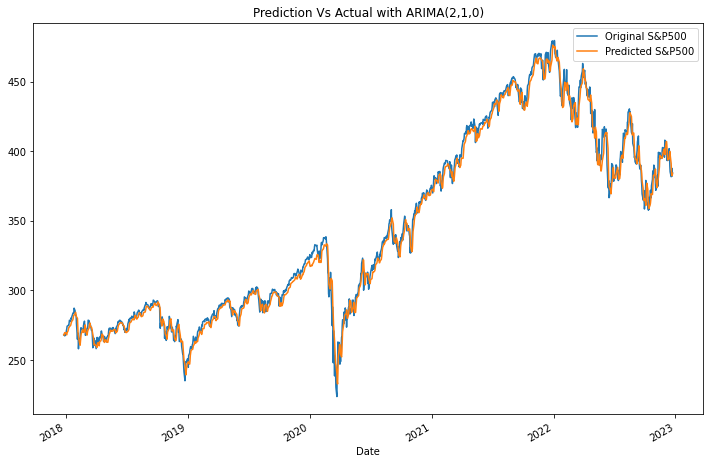

In [56]:
plt.figure(figsize=(12,8))

dfx['SP500'].plot(legend=True, label='Original S&P500')
ARIMA_prediction.plot(legend=True, label='Predicted S&P500')

plt.title('Prediction Vs Actual with ARIMA(2,1,0)')
'RMSE: %.4f'% np.sqrt(sum((ARIMA_prediction-dfx['SP500'])**2)/len(dfx['SP500']))

In [57]:
from sklearn.metrics import mean_absolute_error, r2_score

# y_true is the true values of the target variable
# y_pred is the predicted values of the target variable

mae = mean_absolute_error(dfx['SP500'], ARIMA_prediction)

# Calculate mean absolute percentage error
errors = abs(dfx['SP500'] - ARIMA_prediction)

mape = 100 * (errors / dfx['SP500'])

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

r2 = r2_score(dfx['SP500'], ARIMA_prediction)

Accuracy: 98.65 %.


In [58]:
mae

4.601642721027842

fitting model (1,1,1)

In [73]:
arimax_model1 = ARIMA(df_diff['SP500'], order=(1,1,1), exog = exog).fit()

In [74]:
pred1 = arimax_model1.predict(start=len(train), end=(len(df_diff)-1))
pred1

Date
2021-12-17    0.543411
2021-12-20    0.624368
2021-12-21    0.676317
2021-12-22   -1.002391
2021-12-23   -0.569815
                ...   
2022-12-19    0.824927
2022-12-20    0.712067
2022-12-21    0.224792
2022-12-22   -0.436783
2022-12-23    0.981216
Name: predicted_mean, Length: 257, dtype: float64

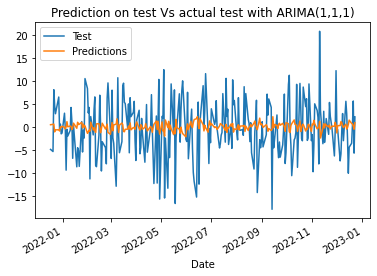

In [75]:
#train.plot(figsize= (10,6))
plt.title('Prediction on test Vs actual test with ARIMA(1,1,1)')

test['SP500'].plot(legend=True, label='Test')
pred1.plot(legend=True, label='Predictions')

In [76]:
ARIMA_diff_predictions1 = pd.Series(arimax_model1.fittedvalues, copy=True)
print(ARIMA_diff_predictions1.head())

ARIMA_diff_predictions_cumsum1 = ARIMA_diff_predictions1.cumsum()
print(ARIMA_diff_predictions_cumsum1.head())

ARIMA_prediction1 = pd.Series(dfx['SP500'].iloc[0], index=dfx['SP500'].index)
ARIMA_prediction1 = ARIMA_prediction1.add(ARIMA_diff_predictions_cumsum1,fill_value=0)
ARIMA_prediction1.head()

Date
2017-12-28    0.379667
2017-12-29    0.491997
2018-01-02   -0.375059
2018-01-03   -0.364445
2018-01-04    0.275016
dtype: float64
Date
2017-12-28    0.379667
2017-12-29    0.871664
2018-01-02    0.496605
2018-01-03    0.132160
2018-01-04    0.407176
dtype: float64


Date
2017-12-26    268.050000
2017-12-27    268.050000
2017-12-28    268.429667
2017-12-29    268.921664
2018-01-02    268.546605
dtype: float64

'RMSE: 60.6253'

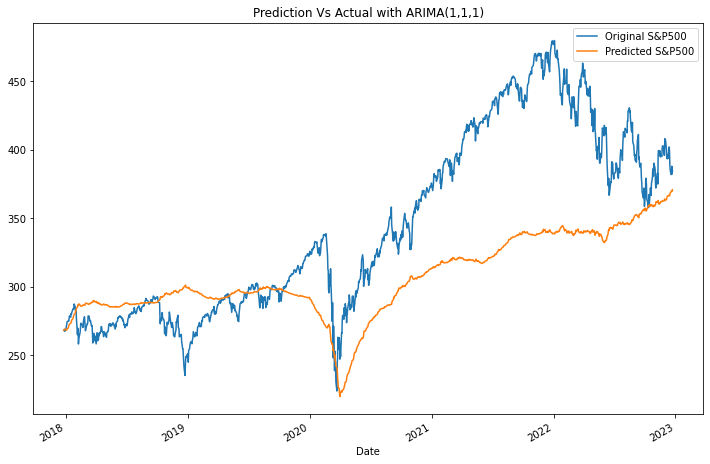

In [77]:
plt.figure(figsize=(12,8))
dfx['SP500'].plot(legend=True, label='Original S&P500')
ARIMA_prediction1.plot(legend=True, label='Predicted S&P500')

#plt.plot(dfx['SP500'])
#plt.plot(ARIMA_log_prediction1)
plt.title('Prediction Vs Actual with ARIMA(1,1,1)')
'RMSE: %.4f'% np.sqrt(sum((ARIMA_prediction1-dfx['SP500'])**2)/len(dfx['SP500']))

In [78]:
from sklearn.metrics import mean_absolute_error, r2_score

# y_true is the true values of the target variable
# y_pred is the predicted values of the target variable

mae = mean_absolute_error(dfx['SP500'], ARIMA_prediction1)

# Calculate mean absolute percentage error
errors = abs(dfx['SP500'] - ARIMA_prediction1)

mape = 100 * (errors / dfx['SP500'])

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

r2 = r2_score(dfx['SP500'], ARIMA_prediction1)

Accuracy: 87.75 %.


In [79]:
mae, r2

(46.69340829809595, 0.18050361918361357)